### load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dfl = []

In [3]:
fnl = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']

In [4]:
for filename in fnl:
    df = pd.read_csv(f'../data/{filename}.csv', delimiter=';')
    dfl.append(df)
    print(f'read {filename}')

read monday
read tuesday
read wednesday
read thursday
read friday


In [5]:
for df in dfl:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.rename(columns = {'customer_no':'customer'}, inplace = True)

In [6]:
dfl[0]

,timestamp,customer,location
0,2019-09-02 07:03:00,1,dairy
1,2019-09-02 07:03:00,2,dairy
2,2019-09-02 07:04:00,3,dairy
3,2019-09-02 07:04:00,4,dairy
4,2019-09-02 07:04:00,5,spices
...,...,...,...
4879,2019-09-02 21:49:00,1442,checkout
4880,2019-09-02 21:49:00,1444,checkout
4881,2019-09-02 21:49:00,1445,dairy
4882,2019-09-02 21:50:00,1446,dairy


### add checkout if missing

In [7]:
for df in dfl:
    
    opening_time = df.timestamp.min()
    closing_time = df.timestamp.max() + pd.DateOffset(minutes=1)
    print(opening_time)
    print(closing_time)
    
    for i in df.customer.unique():
        if df[(df.customer == i) & (df.location == 'checkout')].empty:
            df.loc[len(df)] = [closing_time, i, 'checkout']
            print(f'customer {i} force checkout')
    print(df.customer.max() , df[df.location == 'checkout'].location.count())

print('done')

2019-09-02 07:03:00
2019-09-02 21:51:00
customer 1430 force checkout
customer 1433 force checkout
customer 1437 force checkout
customer 1439 force checkout
customer 1440 force checkout
customer 1441 force checkout
customer 1443 force checkout
customer 1445 force checkout
customer 1446 force checkout
customer 1447 force checkout
1447 1447
2019-09-03 07:02:00
2019-09-03 21:51:00
customer 1411 force checkout
customer 1422 force checkout
1422 1422
2019-09-04 07:00:00
2019-09-04 21:50:00
customer 1520 force checkout
customer 1527 force checkout
customer 1528 force checkout
customer 1529 force checkout
customer 1530 force checkout
1531 1531
2019-09-05 07:00:00
2019-09-05 21:50:00
customer 1527 force checkout
customer 1532 force checkout
customer 1533 force checkout
1535 1535
2019-09-06 07:00:00
2019-09-06 21:51:00
customer 1494 force checkout
customer 1496 force checkout
customer 1500 force checkout
customer 1503 force checkout
customer 1505 force checkout
customer 1506 force checkout
custom

In [8]:
# total count of entries
n_total = 0
for df in dfl:
    n_total += df.shape[0]
n_total

24905

### customer filter test area

In [13]:
mydf = dfl[0][dfl[0].customer == 446]
mydf

,timestamp,customer,location
1477,2019-09-02 12:05:00,446,dairy
1487,2019-09-02 12:08:00,446,fruit
1493,2019-09-02 12:10:00,446,dairy
1497,2019-09-02 12:11:00,446,checkout


In [15]:
mydf.index.max()

1497

In [18]:
mydf.iloc[-1].location

'checkout'

In [29]:
(mydf.iloc[1]['timestamp'] - mydf.iloc[0]['timestamp']) / pd.Timedelta(minutes=1)

3.0

### create transition dataframe

In [113]:
transitions = pd.DataFrame(columns=['location', 'following'])

for df in dfl:
    for cid in df.customer.unique():
        transitions = transitions.append(df[df.customer == cid][['location']], ignore_index=True)
    print(df.shape)

(4894, 3)
(4716, 3)
(5055, 3)
(5107, 3)
(5133, 3)


In [33]:
# append rows to empty dataframe
# PROFILING: took 165 s

In [42]:
transitions = pd.DataFrame(' ', index=np.arange(n_total), columns=['location', 'following'])

i = 0
for df in dfl:
    for cid in df.customer.unique():
        for index, row in df[df.customer == cid].iterrows():
            transitions.at[i, 'location'] = row.location
            i += 1
    print(i)

4894
9610
14665
19772
24905


In [31]:
# set values in dataframe with dummy rows
# PROFILING: took 15 s

In [43]:
trans_arr = np.full((n_total, 2), ' ', dtype='<U8')

i = 0
for df in dfl:
    for cid in df.customer.unique():
        for index, row in df[df.customer == cid].iterrows():
            trans_arr[i][0] = row.location
            i += 1
    print(i)

transitions = pd.DataFrame(trans_arr, columns=['location', 'following'])

4894
9610
14665
19772
24905


In [32]:
# set values in numpy array, in the end make dataframe
# PROFILING: took 10 s

### shift rows

In [44]:
transitions

,location,following
0,dairy,
1,checkout,
2,dairy,
3,checkout,
4,dairy,
...,...,...
24900,checkout,
24901,drinks,
24902,checkout,
24903,spices,


In [45]:
transitions['following'] = transitions['location'].shift(-1)

In [46]:
transitions

,location,following
0,dairy,checkout
1,checkout,dairy
2,dairy,checkout
3,checkout,dairy
4,dairy,checkout
...,...,...
24900,checkout,drinks
24901,drinks,checkout
24902,checkout,spices
24903,spices,checkout


### create markov probabilities crosstab

In [47]:
mycrosstab = pd.crosstab(transitions['location'], transitions['following'], normalize=0)

In [48]:
myentry = mycrosstab[0:1].copy()
myentry

following,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,0.0,0.28748,0.153546,0.377485,0.181488


In [49]:
mycrosstab.iloc[0] = np.array([1.0, 0.0, 0.0, 0.0, 0.0])
mycrosstab

following,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.393033,0.000000,0.222483,0.189357,0.195127
drinks,0.537260,0.027145,0.000000,0.218950,0.216645
fruit,0.500195,0.237993,0.136080,0.000000,0.125732
spices,0.251998,0.323122,0.272776,0.152104,0.000000


In [122]:
import seaborn as sns

<AxesSubplot:xlabel='following', ylabel='location'>

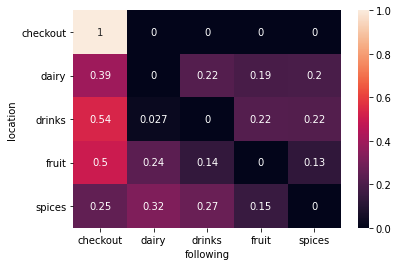

In [130]:
sns.heatmap(mycrosstab, annot=True)

<AxesSubplot:xlabel='following', ylabel='location'>

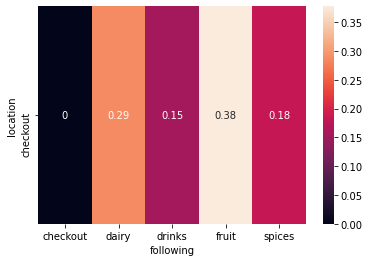

In [131]:
sns.heatmap(myentry, annot=True)

In [113]:
print(list(mycrosstab.index.values))
for index, row in mycrosstab.iterrows():
    print(row.sum(), list(row))

print('')
print(myentry.iloc[0].sum(), list(myentry.iloc[0]))

['checkout', 'dairy', 'drinks', 'fruit', 'spices']
1.0 [1.0, 0.0, 0.0, 0.0, 0.0]
1.0 [0.3930326992947211, 0.0, 0.22248343663175893, 0.18935670014960462, 0.19512716392391535]
1.0 [0.5372599231754162, 0.02714468629961588, 0.0, 0.21895006402048656, 0.21664532650448143]
1.0 [0.5001952362358454, 0.23799297149550958, 0.13607965638422492, 0.0, 0.12573213588442014]
1.0 [0.25199786893979753, 0.3231220031965903, 0.27277570591369205, 0.15210442194992008, 0.0]

1.0 [0.0, 0.28747984954325634, 0.15354648038688876, 0.37748522299838794, 0.18148844707146694]


### test simulation

In [78]:
E = np.array([
            [0.0, 0.28747985, 0.15354648, 0.37748522, 0.18148845],
            [0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0]
        ])

In [79]:
T = np.array([
            [1.0, 0.0, 0.0, 0.0, 0.0],
            [0.3930326992947211, 0.0, 0.22248343663175893, 0.18935670014960462, 0.19512716392391535],
            [0.5372599231754162, 0.02714468629961588, 0.0, 0.21895006402048656, 0.21664532650448143],
            [0.5001952362358454, 0.23799297149550958, 0.13607965638422492, 0.0, 0.12573213588442014],
            [0.25199786893979753, 0.3231220031965903, 0.27277570591369205, 0.15210442194992008, 0.0]
        ])

In [106]:
n = 1000
s = np.array([n, 0, 0, 0, 0])
print(s, s.sum())

s = s.dot(E)
print(s.round(), s.sum())

while s[0].round() < n:
    s = s.dot(T)
    print(s.round(), s.sum())

[1000    0    0    0    0] 1000
[  0. 287. 154. 377. 181.] 1000.0
[430. 153. 165. 116. 137.] 1000.0000000000001
[671.  76.  87.  86.  80.] 1000.0000000000001
[811.  49.  50.  46.  45.] 1000.0000000000002
[891.  27.  29.  27.  26.] 1000.0000000000001
[937.  16.  17.  15.  15.] 1000.0000000000001
[964.   9.  10.   9.   9.] 1000.0000000000001
[979.   5.   6.   5.   5.] 1000.0000000000003
[988.   3.   3.   3.   3.] 1000.0000000000003
[993.   2.   2.   2.   2.] 1000.0000000000003
[996.   1.   1.   1.   1.] 1000.0000000000003
[998.   1.   1.   1.   1.] 1000.0000000000003
[999.   0.   0.   0.   0.] 1000.0000000000003
[999.   0.   0.   0.   0.] 1000.0000000000003
[1000.    0.    0.    0.    0.] 1000.0000000000006
